<a href="https://colab.research.google.com/github/patilshan/Projects/blob/main/Wind_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wind Energy Assessment Project

## **Introduction**
This project aims to analyze the wind resource and estimate the energy production potential of the Lone Star Wind Farm located at **299 FM 604, Abilene, TX 79601, USA**. The wind resource data was sourced from the **NREL WRDB: Wind Resource Database**, focusing on the year **2020**.

The analysis uses wind resource data at **100m hub height** for the turbine model **GAMESA G87-2.0 MW**, which includes the manufacturer's power curve and turbine specifications.

### **Objectives**
1. Assess the wind resource potential by analyzing wind speed, direction, air pressure, and temperature.
2. Fit a **Weibull distribution** to understand the wind speed distribution.
3. Estimate the theoretical and adjusted energy production using the turbine's power curve and air density adjustments.
4. Provide insights into seasonal and hourly trends in wind speed.
5. Deliver actionable metrics, such as the **capacity factor** and **annualized energy yield**.

### **Data Description**
- **Source**: NREL WRDB
- **Time Period**: January 1, 2020 – December 31, 2020
- **Resolution**: 5-minute intervals
- **Columns**:
  - Timestamp
  - Wind direction (degrees)
  - Wind speed (m/s)
  - Air pressure (Pa)
  - Air temperature (°C)

### **Turbine Details**
- **Model**: GAMESA G87-2.0 MW
- **Rated Capacity**: 2 MW
- **Cut-in Wind Speed**: 4 m/s
- **Cut-out Wind Speed**: 25 m/s


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df1 = pd.read_csv('5mins.csv', header=0)  # Specify header row
df2 = pd.read_csv('60mins.csv', header=0)  # Specify header row
powerc = pd.read_csv('power curve data Gamesa.csv', header=0)  # Specify header row

# Display first few rows of dataframes
df1.head()
df2.head()



,Year,Month,Day,Hour,Minute,air pressure at 100m (Pa),air temperature at 100m (C),wind direction at 100m (deg),wind speed at 100m (m/s)
0,2020,1,1,0,0,94380,7.77,178.48,11.11
1,2020,1,1,1,0,94350,7.47,183.75,12.25
2,2020,1,1,2,0,94290,7.58,191.39,12.72
3,2020,1,1,3,0,94230,6.99,201.18,11.43
4,2020,1,1,4,0,94220,6.77,207.05,10.45


## **Data Cleaning**
The raw wind resource data was preprocessed to handle missing values, filter irrelevant entries, and detect outliers in wind speed, air pressure, and air temperature using the **Interquartile Range (IQR)** method. The turbine's cut-in and cut-out wind speeds were used to remove unrealistic data points.

### **Code Implementation**
Below, the code demonstrates how the outliers were detected and removed:


In [ ]:
# Convert relevant columns to numeric, handling errors
for col in ['Year', 'Month', 'Day', 'Hour', 'Minute']:
    df1[col] = pd.to_numeric(df1[col], errors='coerce')
    df2[col] = pd.to_numeric(df2[col], errors='coerce')

# Create timestamp columns
df1['Timestamp'] = pd.to_datetime(df1[['Year', 'Month', 'Day', 'Hour', 'Minute']])
df2['Timestamp'] = pd.to_datetime(df2[['Year', 'Month', 'Day', 'Hour', 'Minute']])

df1.head()
df2.head()

,Year,Month,Day,Hour,Minute,wind direction at 100m (deg),wind speed at 100m (m/s),Timestamp
0,2020,1,1,0,0,178.29,10.82,2020-01-01 00:00:00
1,2020,1,1,0,5,179.04,10.72,2020-01-01 00:05:00
2,2020,1,1,0,10,179.69,10.74,2020-01-01 00:10:00
3,2020,1,1,0,15,180.07,10.85,2020-01-01 00:15:00
4,2020,1,1,0,20,180.51,11.00,2020-01-01 00:20:00


In [ ]:
# Reordering columns using loc
df1= df1.loc[:, ['Timestamp',	'Year',	'Month',	'Day',	'Hour',	'Minute',	'wind direction at 100m (deg)',	'wind speed at 100m (m/s)'] ]
df2_1= df2.loc[:, ['Timestamp',	'Year',	'Month',	'Day',  'Hour',	'Minute',	'air pressure at 100m (Pa)',	'air temperature at 100m (C)'] ]
df1.head(1000)
df2_1.head(1000)

,Timestamp,Year,Month,Day,Hour,Minute,wind direction at 100m (deg),wind speed at 100m (m/s)
0,2020-01-01 00:00:00,2020,1,1,0,0,178.29,10.82
1,2020-01-01 00:05:00,2020,1,1,0,5,179.04,10.72
2,2020-01-01 00:10:00,2020,1,1,0,10,179.69,10.74
3,2020-01-01 00:15:00,2020,1,1,0,15,180.07,10.85
4,2020-01-01 00:20:00,2020,1,1,0,20,180.51,11.00
...,...,...,...,...,...,...,...,...
995,2020-01-04 10:55:00,2020,1,4,10,55,338.10,1.70
996,2020-01-04 11:00:00,2020,1,4,11,0,341.08,1.71
997,2020-01-04 11:05:00,2020,1,4,11,5,344.28,1.73
998,2020-01-04 11:10:00,2020,1,4,11,10,345.67,1.68


In [ ]:
# Check data types
print("Data types for df1:")
print(df1.dtypes)
print("\nData types for df2_1:")
print(df2_1.dtypes)

# Check for missing values
print("\nMissing values in df1:")
print(df1.isnull().sum())
print("\nMissing values in df2:")
print(df2_1.isnull().sum())

Data types for df1:
Timestamp                       datetime64[ns]
Year                                     int64
Month                                    int64
Day                                      int64
Hour                                     int64
Minute                                   int64
wind direction at 100m (deg)           float64
wind speed at 100m (m/s)               float64
dtype: object

Data types for df2_1:
Timestamp                      datetime64[ns]
Year                                    int64
Month                                   int64
Day                                     int64
Hour                                    int64
Minute                                  int64
air pressure at 100m (Pa)               int64
air temperature at 100m (C)           float64
dtype: object

Missing values in df1:
Timestamp                       0
Year                            0
Month                           0
Day                             0
Hour                     

In [ ]:
df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])
df2_1['Timestamp'] = pd.to_datetime(df2_1['Timestamp'])
# Merge based on the hour, filling hourly values into the 5-minute intervals
df1['Hour'] = df1['Timestamp'].dt.floor('H')  # Create a new Hour column aligned with hourly intervals
df_merged = pd.merge(df1, df2_1[['Timestamp', 'air pressure at 100m (Pa)', 'air temperature at 100m (C)']],
                     left_on='Hour', right_on='Timestamp', how='left')

# Drop unnecessary Timestamp_y and rename columns
df_merged.drop(columns=['Timestamp_y'], inplace=True)
df_merged.rename(columns={'Timestamp_x': 'Timestamp'}, inplace=True)

# Display the merged dataframe
df_merged.head(1000)

<ipython-input-7-3716484130f7>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df1['Hour'] = df1['Timestamp'].dt.floor('H')  # Create a new Hour column aligned with hourly intervals


,Timestamp,Year,Month,Day,Hour,Minute,wind direction at 100m (deg),wind speed at 100m (m/s),air pressure at 100m (Pa),air temperature at 100m (C)
0,2020-01-01 00:00:00,2020,1,1,2020-01-01 00:00:00,0,178.29,10.82,94380,7.77
1,2020-01-01 00:05:00,2020,1,1,2020-01-01 00:00:00,5,179.04,10.72,94380,7.77
2,2020-01-01 00:10:00,2020,1,1,2020-01-01 00:00:00,10,179.69,10.74,94380,7.77
3,2020-01-01 00:15:00,2020,1,1,2020-01-01 00:00:00,15,180.07,10.85,94380,7.77
4,2020-01-01 00:20:00,2020,1,1,2020-01-01 00:00:00,20,180.51,11.00,94380,7.77
...,...,...,...,...,...,...,...,...,...,...
995,2020-01-04 10:55:00,2020,1,4,2020-01-04 10:00:00,55,338.10,1.70,95430,3.12
996,2020-01-04 11:00:00,2020,1,4,2020-01-04 11:00:00,0,341.08,1.71,95410,5.38
997,2020-01-04 11:05:00,2020,1,4,2020-01-04 11:00:00,5,344.28,1.73,95410,5.38
998,2020-01-04 11:10:00,2020,1,4,2020-01-04 11:00:00,10,345.67,1.68,95410,5.38


In [ ]:
# Extract the hour as an integer from the 'Hour' column and update the column
df_merged['Hour'] = df_merged['Hour'].dt.hour
df_merged.head(1000)

,Timestamp,Year,Month,Day,Hour,Minute,wind direction at 100m (deg),wind speed at 100m (m/s),air pressure at 100m (Pa),air temperature at 100m (C)
0,2020-01-01 00:00:00,2020,1,1,0,0,178.29,10.82,94380,7.77
1,2020-01-01 00:05:00,2020,1,1,0,5,179.04,10.72,94380,7.77
2,2020-01-01 00:10:00,2020,1,1,0,10,179.69,10.74,94380,7.77
3,2020-01-01 00:15:00,2020,1,1,0,15,180.07,10.85,94380,7.77
4,2020-01-01 00:20:00,2020,1,1,0,20,180.51,11.00,94380,7.77
...,...,...,...,...,...,...,...,...,...,...
995,2020-01-04 10:55:00,2020,1,4,10,55,338.10,1.70,95430,3.12
996,2020-01-04 11:00:00,2020,1,4,11,0,341.08,1.71,95410,5.38
997,2020-01-04 11:05:00,2020,1,4,11,5,344.28,1.73,95410,5.38
998,2020-01-04 11:10:00,2020,1,4,11,10,345.67,1.68,95410,5.38


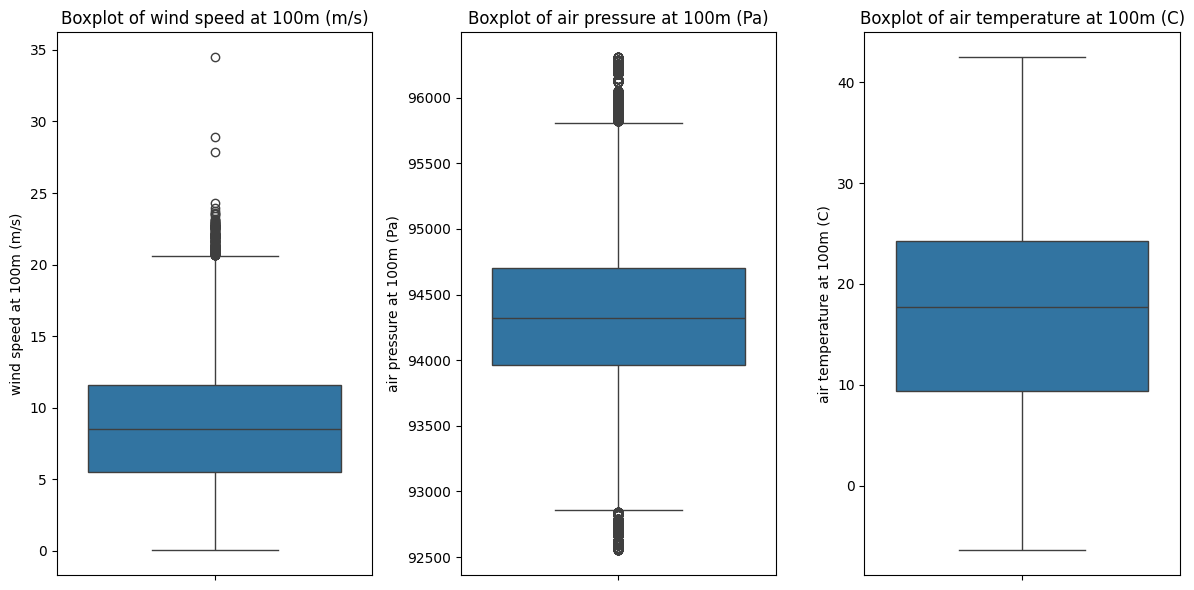

In [ ]:
# Select columns for boxplot (replace with your actual column names)
numerical_cols = ['wind speed at 100m (m/s)', 'air pressure at 100m (Pa)', 'air temperature at 100m (C)']

# Create the boxplots
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i + 1)
    sns.boxplot(y=df_merged[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [ ]:
# Select columns for outlier detection (replace with your actual column names)
numerical_cols = ['wind speed at 100m (m/s)', 'air pressure at 100m (Pa)', 'air temperature at 100m (C)']

for col in numerical_cols:
    # Calculate Q1, Q3, and IQR
    Q1 = df_merged[col].quantile(0.25)
    Q3 = df_merged[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = df_merged[(df_merged[col] < lower_bound) | (df_merged[col] > upper_bound)]
    outlier_percentage = (len(outliers) / len(df_merged)) * 100

    print(f"Percentage of outliers in {col}: {outlier_percentage:.2f}%")

Percentage of outliers in wind speed at 100m (m/s): 0.18%
Percentage of outliers in air pressure at 100m (Pa): 1.50%
Percentage of outliers in air temperature at 100m (C): 0.00%


### **Outlier Summary**
- **Wind Speed Outliers**: 0.18% of data
- **Air Pressure Outliers**: 1.50% of data
- **Air Temperature Outliers**: 0.00% of data



# **Handling** **Outliers**

As the cutoff speed of the turbine is 4 m/s and 25 m/s all the other data points are not operational.

In [ ]:
# Remove wind speed outliers outside the operational range
cut_in_speed = 4  # Minimum operational speed
cut_out_speed = 25  # Maximum operational speed

# Filter the dataframe
df_cleaned = df_merged[(df_merged['wind speed at 100m (m/s)'] >= cut_in_speed) &
                       (df_merged['wind speed at 100m (m/s)'] <= cut_out_speed)]

# Check the percentage of data retained
print(f"Data retained after handling wind speed outliers: {len(df_cleaned) / len(df_merged) * 100:.2f}%")


Data retained after handling wind speed outliers: 86.68%


In [ ]:

numerical_cols = ['wind speed at 100m (m/s)', 'air pressure at 100m (Pa)', 'air temperature at 100m (C)']

for col in numerical_cols:
    # Calculate Q1, Q3, and IQR
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
    outlier_percentage = (len(outliers) / len(df_cleaned)) * 100

    print(f"Percentage of outliers in {col}: {outlier_percentage:.2f}%")

Percentage of outliers in wind speed at 100m (m/s): 0.36%
Percentage of outliers in air pressure at 100m (Pa): 1.54%
Percentage of outliers in air temperature at 100m (C): 0.00%


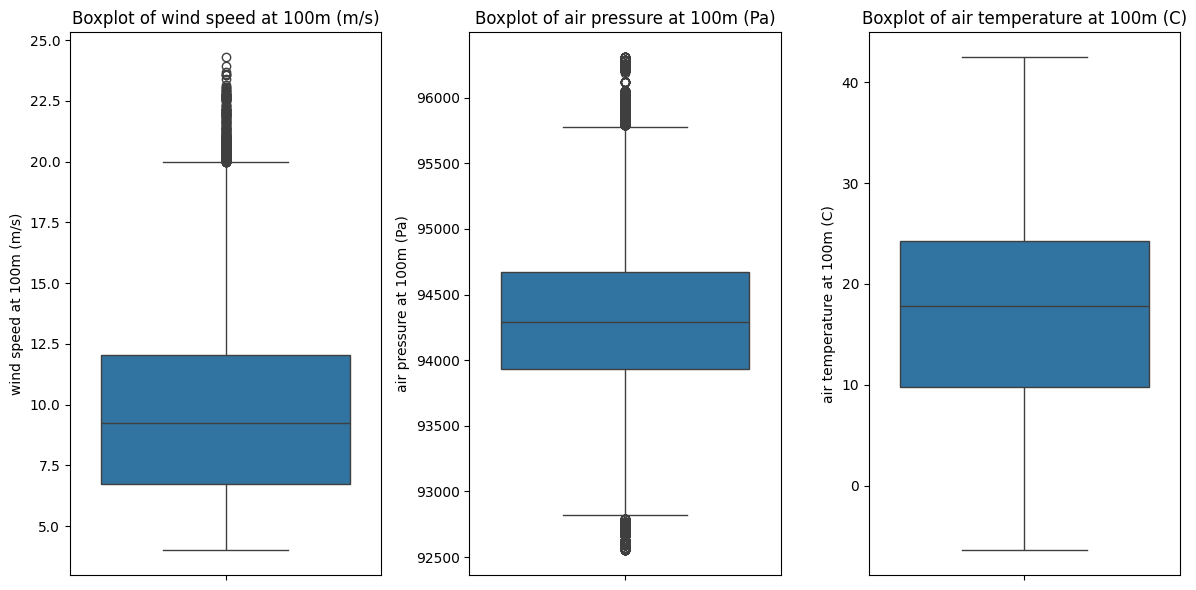

In [ ]:
numerical_cols = ['wind speed at 100m (m/s)', 'air pressure at 100m (Pa)', 'air temperature at 100m (C)']

# Create the boxplots
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i + 1)
    sns.boxplot(y=df_cleaned[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

# **Exploratory Data Analysis:**

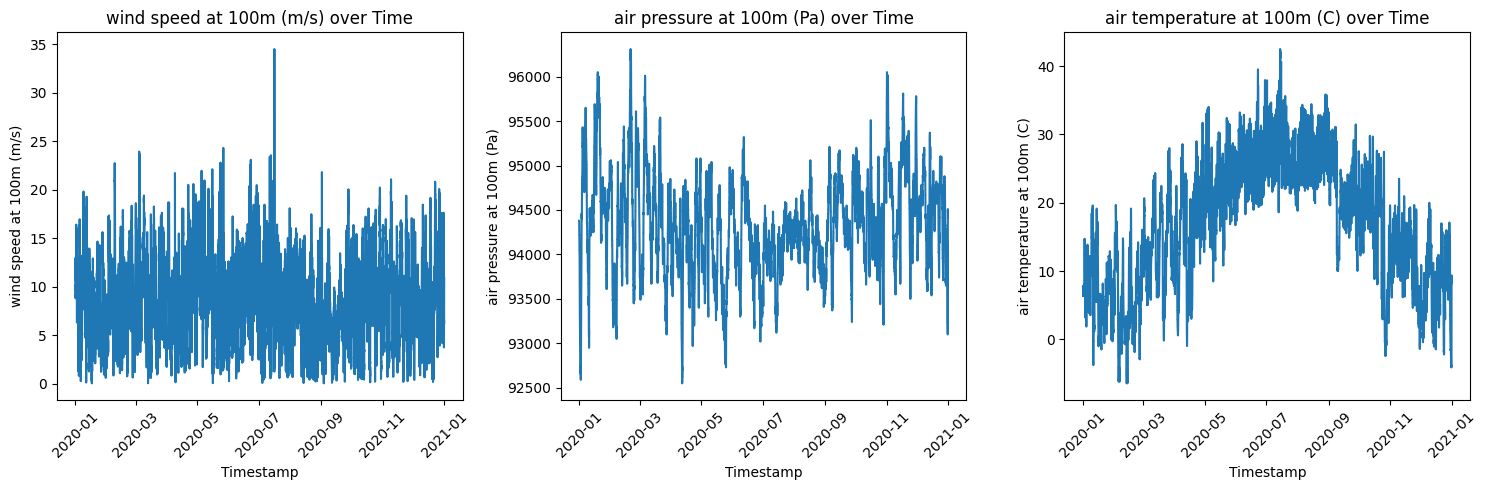

In [ ]:
# Select columns for plotting (replace with your actual column names)
columns_to_plot = ['wind speed at 100m (m/s)', 'air pressure at 100m (Pa)', 'air temperature at 100m (C)']

# Create the plots
plt.figure(figsize=(15, 5))  # Adjust figure size as needed

for i, col in enumerate(columns_to_plot):
    plt.subplot(1, len(columns_to_plot), i + 1)  # Create subplots for each column
    plt.plot(df_merged['Timestamp'], df_merged[col])  # Plot the column against the timestamp
    plt.title(f'{col} over Time')
    plt.xlabel('Timestamp')
    plt.ylabel(col)
    plt.xticks(rotation=45) # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

**Rose** **Plot**

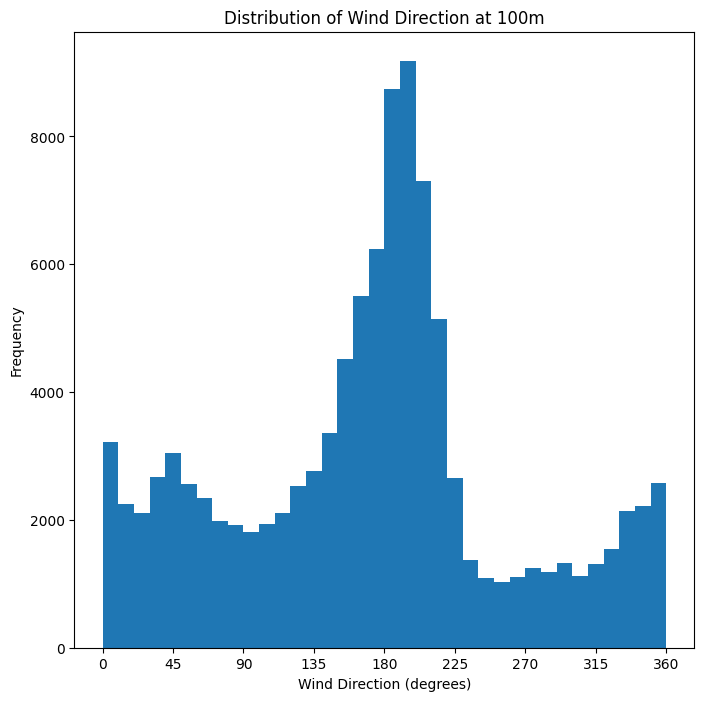

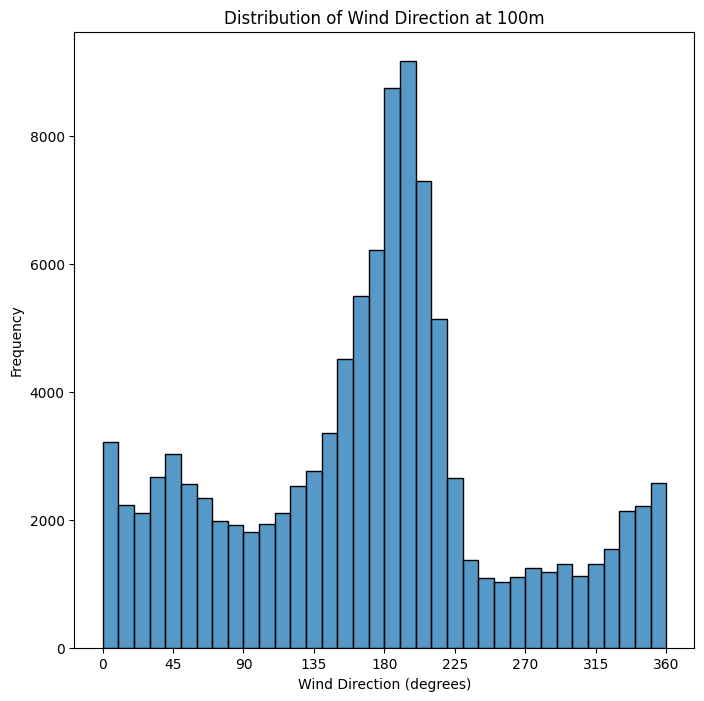

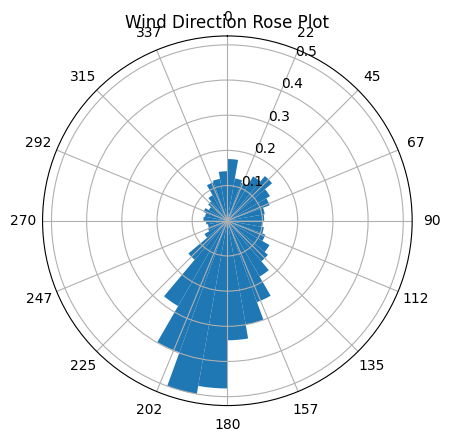

In [ ]:
plt.figure(figsize=(8, 8))
plt.hist(df_merged['wind direction at 100m (deg)'], bins=36, range=(0, 360))  # 36 bins for 10-degree intervals
plt.title('Distribution of Wind Direction at 100m')
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 361, 45)) # Customize x-axis ticks for better readability
plt.show()

#Alternative plot using seaborn
plt.figure(figsize=(8, 8))
sns.histplot(df_merged['wind direction at 100m (deg)'], bins=36, kde=False)
plt.title('Distribution of Wind Direction at 100m')
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 361, 45))
plt.show()

#

# Extract the wind direction data
wind_directions = df_merged['wind direction at 100m (deg)']

# Create a polar plot (rose plot)
ax = plt.subplot(111, projection='polar')
n, bins, patches = ax.hist(np.deg2rad(wind_directions), bins=36, range=(0, 2*np.pi), density=True) # Convert to radians

# Set the angle labels
ax.set_xticks(np.arange(0, 2*np.pi, np.pi/8)) #Adjust as needed
ax.set_xticklabels([str(int(angle * 180 / np.pi)) for angle in np.arange(0, 2*np.pi, np.pi/8)])


# Customize plot appearance
ax.set_title('Wind Direction Rose Plot')
ax.set_theta_zero_location("N") # Set north at the top of the plot
ax.set_theta_direction(-1)

plt.show()

## **Seasonal and Hourly Trends**
Seasonal and hourly trends were analyzed to identify high-performing periods for energy generation.



### **Code Implementation**


<ipython-input-29-6e76c29a1bf7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Timestamp'] = pd.to_datetime(df_cleaned['Timestamp'])
<ipython-input-29-6e76c29a1bf7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Season'] = df_cleaned['Month'].map({
<ipython-input-29-6e76c29a1bf7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

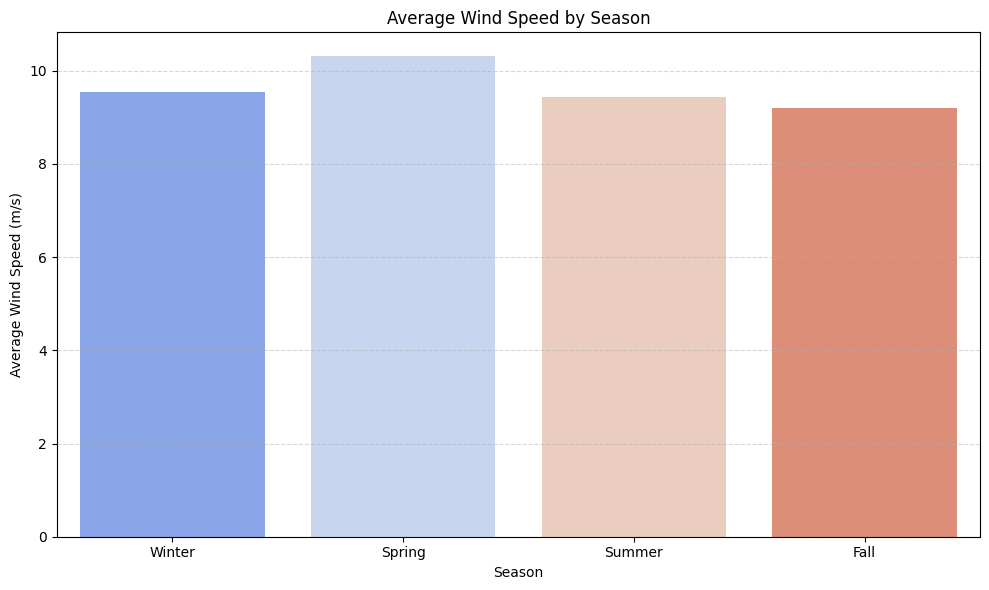

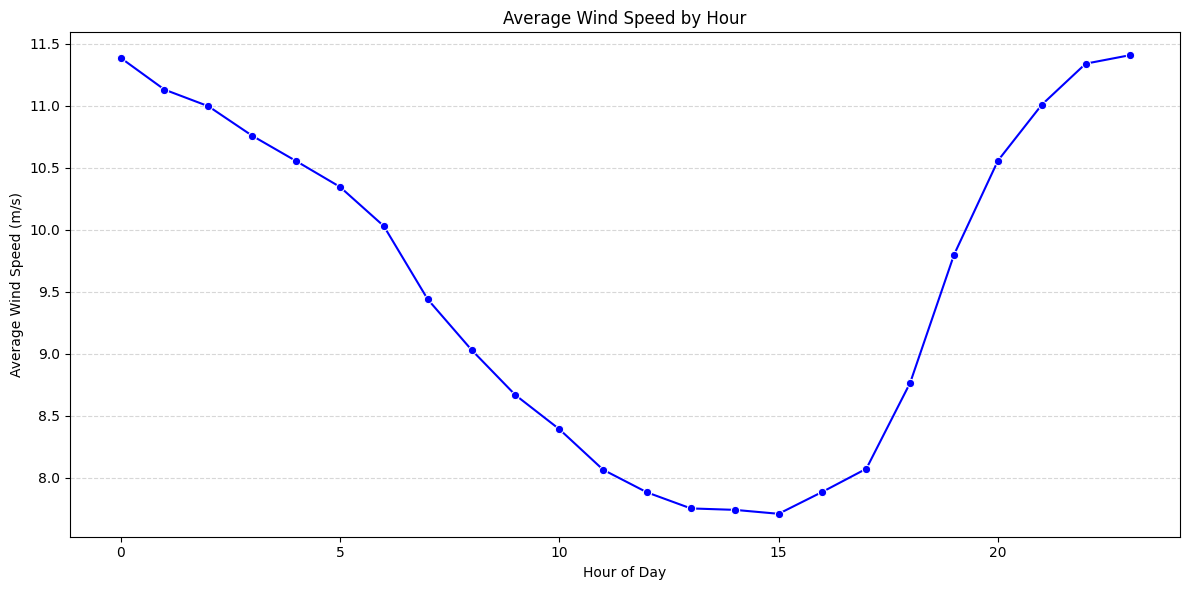

In [ ]:
# Ensure Timestamp is in datetime format
df_cleaned['Timestamp'] = pd.to_datetime(df_cleaned['Timestamp'])

# Extract relevant time-based features
df_cleaned['Season'] = df_cleaned['Month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})
df_cleaned['Hour'] = df_cleaned['Timestamp'].dt.hour

# Seasonal Grouping
seasonal_data = df_cleaned.groupby('Season')['wind speed at 100m (m/s)'].mean().reset_index()

# Hourly Grouping
hourly_data = df_cleaned.groupby('Hour')['wind speed at 100m (m/s)'].mean().reset_index()

# Step 1: Plot Seasonal Trends
plt.figure(figsize=(10, 6))
sns.barplot(data=seasonal_data, x='Season', y='wind speed at 100m (m/s)', order=['Winter', 'Spring', 'Summer', 'Fall'], palette='coolwarm')
plt.title('Average Wind Speed by Season')
plt.xlabel('Season')
plt.ylabel('Average Wind Speed (m/s)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Step 2: Plot Hourly Trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_data, x='Hour', y='wind speed at 100m (m/s)', marker='o', color='blue')
plt.title('Average Wind Speed by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Wind Speed (m/s)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### **Key Observations**
- **Seasonal Trends**:
  - Highest wind speeds observed in Spring.
  - Lowest wind speeds observed in Fall.

- **Hourly Trends**:
  - Peak wind speeds occur in the early morning hours (4–7 AM).


## **Weibull Distribution Analysis**
The wind speed data was fitted to a **Weibull distribution** to quantify the wind resource potential. Key parameters calculated:
- **Shape Parameter (k\)**: 2.92 (indicates a consistent wind resource)
- **Scale Parameter (c\)**: 10.82 m/s (average wind speed)

### **Code Implementation**


Weibull Shape Parameter (k): 2.92
Weibull Scale Parameter (c): 10.82


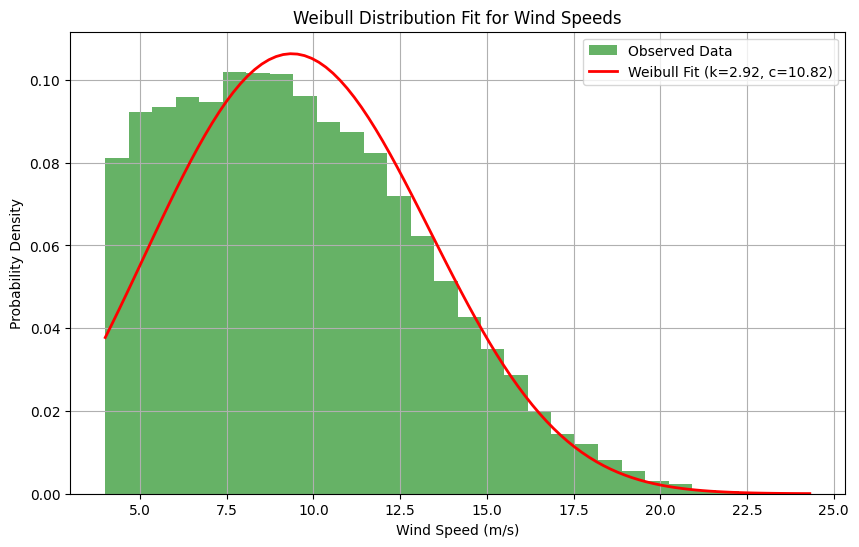

In [ ]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt

# Step 1: Extract wind speed data for analysis
wind_speeds = df_cleaned['wind speed at 100m (m/s)']

# Step 2: Fit the Weibull distribution
shape, loc, scale = weibull_min.fit(wind_speeds, floc=0)  # Fix location at 0 (standard Weibull)
print(f"Weibull Shape Parameter (k): {shape:.2f}")
print(f"Weibull Scale Parameter (c): {scale:.2f}")

# Step 3: Create a histogram of the wind speed data
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(wind_speeds, bins=30, density=True, alpha=0.6, color='g', label='Observed Data')

# Step 4: Plot the fitted Weibull PDF
x = np.linspace(min(wind_speeds), max(wind_speeds), 100)
pdf = weibull_min.pdf(x, shape, loc, scale)  # Weibull probability density function
plt.plot(x, pdf, 'r-', lw=2, label=f'Weibull Fit (k={shape:.2f}, c={scale:.2f})')

# Step 5: Add labels and legend
plt.title('Weibull Distribution Fit for Wind Speeds')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid()
plt.show()

Key Weibull Parameters
Shape Parameter (k=2.92):

The shape parameter describes the distribution's skewness.
𝑘 > 2 suggests a relatively narrow spread of wind speeds, indicating that the wind resource is consistent and not extremely variable.

Scale Parameter (c=10.82):

The scale parameter is roughly the average wind speed.
c = 10.82m/s indicates that the average wind speed at this site is around 10.82 m/s.

## **Power Curve Analysis**
The turbine's power output was calculated based on the manufacturer's power curve. Additionally, the power curve was adjusted for site-specific air density variations.

### **Key Calculations**
1. **Air Density**:
   Air density was calculated using the formula:
 $$ \rho = \frac{P}{R \cdot T} $$
   where:
   - \(P\): Air pressure in Pa
   - \(R = 287.0\): Specific gas constant for air
   - \(T\): Air temperature in Kelvin

2. **Power Adjustment**:
   Adjusted power output was derived using:
$$ P_{\text{adjusted}} = P_{\text{original}} \cdot \frac{\rho_{\text{local}}}{\rho_{\text{reference}}} $$


### **Code Implementation**


# Manufacturer's Power Curve:

In [ ]:
powerc.head()

,Speed (m/s),Power (kW)
0,4,78.6
1,5,181.2
2,6,335.4
3,7,549.8
4,8,831.5


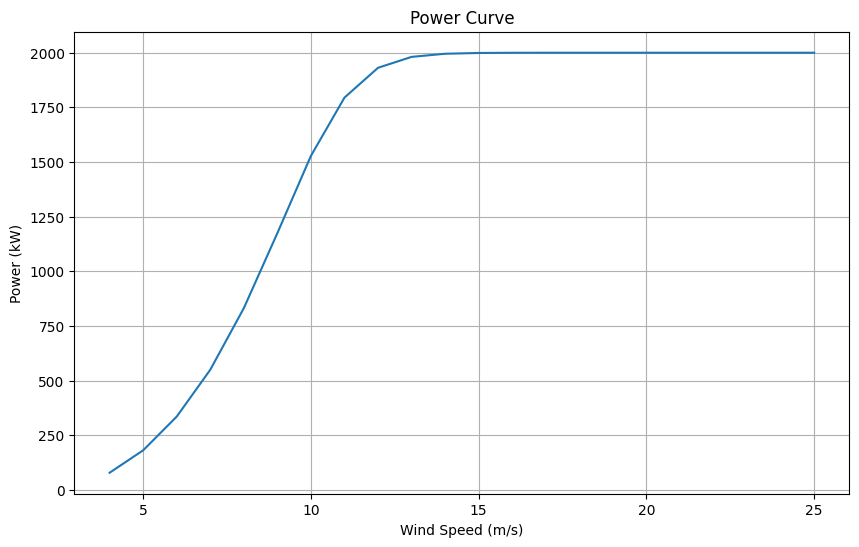

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(powerc['Speed (m/s)'], powerc['Power (kW)'])
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Power Curve')
plt.grid(True)
plt.show()

# Comparing the Theoretical Power Output and Manufacturer Power Curve

<ipython-input-18-584e1f741714>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['theoretical_power_output (kW)'] = interp_func(df_cleaned['wind speed at 100m (m/s)'])


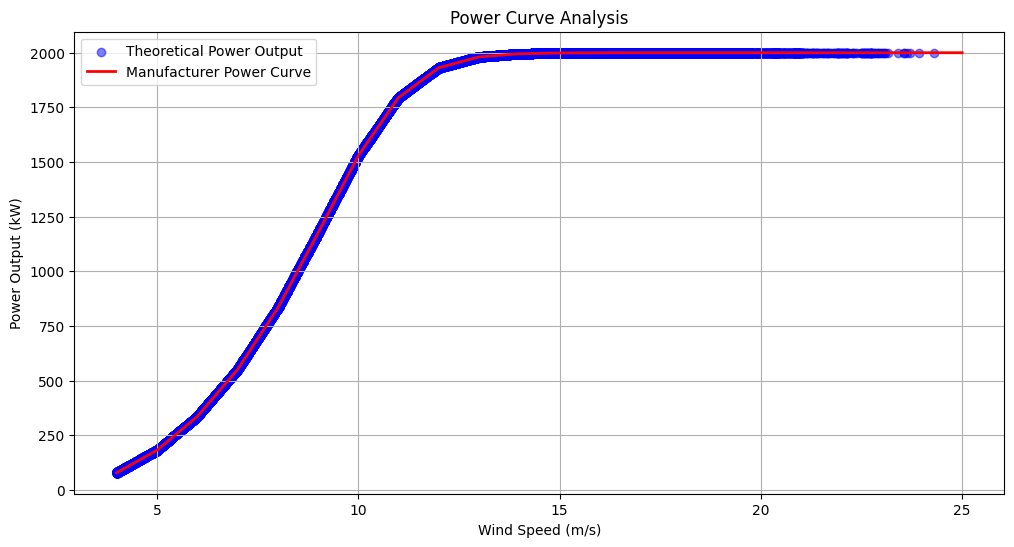

Summary Statistics for Theoretical Power Output:
count    91118.000000
mean      1189.906152
std        693.360656
min         78.600000
25%        496.200000
50%       1263.175000
75%       1933.096000
max       2000.000000
Name: theoretical_power_output (kW), dtype: float64


In [ ]:
from scipy.interpolate import interp1d
wind_speeds = powerc['Speed (m/s)']
power_values = powerc['Power (kW)']

# Create an interpolation function for the power curve
interp_func = interp1d(wind_speeds, power_values, fill_value=0, bounds_error=False)

# Step 2: Map wind speeds in 'df_cleaned' to the power curve
df_cleaned['theoretical_power_output (kW)'] = interp_func(df_cleaned['wind speed at 100m (m/s)'])

# Step 3: Plot the power curve and sample data
plt.figure(figsize=(12, 6))
plt.scatter(df_cleaned['wind speed at 100m (m/s)'], df_cleaned['theoretical_power_output (kW)'],
            label='Theoretical Power Output', alpha=0.5, color='blue')
plt.plot(wind_speeds, power_values, label='Manufacturer Power Curve', color='red', linewidth=2)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('Power Curve Analysis')
plt.legend()
plt.grid()
plt.show()

# Step 4: Summary statistics for theoretical power output
summary_stats = df_cleaned['theoretical_power_output (kW)'].describe()
print("Summary Statistics for Theoretical Power Output:")
print(summary_stats)

Interpolation Function:

The interp1d function creates a smooth mapping between wind speed and power output based on the manufacturer-provided power curve.
If a wind speed is outside the manufacturer-provided range, the function assigns 0 power (using fill_value=0).
Mapping Wind Speeds:

The cleaned wind speed data (df_cleaned['wind speed at 100m (m/s)']) is mapped to the turbine's power curve to calculate the theoretical power output.
Visualization:

A scatter plot of the calculated theoretical power output is overlaid on the manufacturer's power curve to validate turbine performance visually.
Summary Statistics:

The calculated theoretical power output is summarized using descriptive statistics (mean, min, max, etc.) to provide insights into the dataset.

In [ ]:
total_power_output = df_cleaned['theoretical_power_output (kW)'].sum()
max_possible_output = 2000 * len(df_cleaned) * (5 / 60)  # Assuming max capacity is 2000 kW and 5-min intervals
capacity_factor = total_power_output / max_possible_output * 100
print(f"Capacity Factor: {capacity_factor:.2f}%")


Capacity Factor: 713.94%


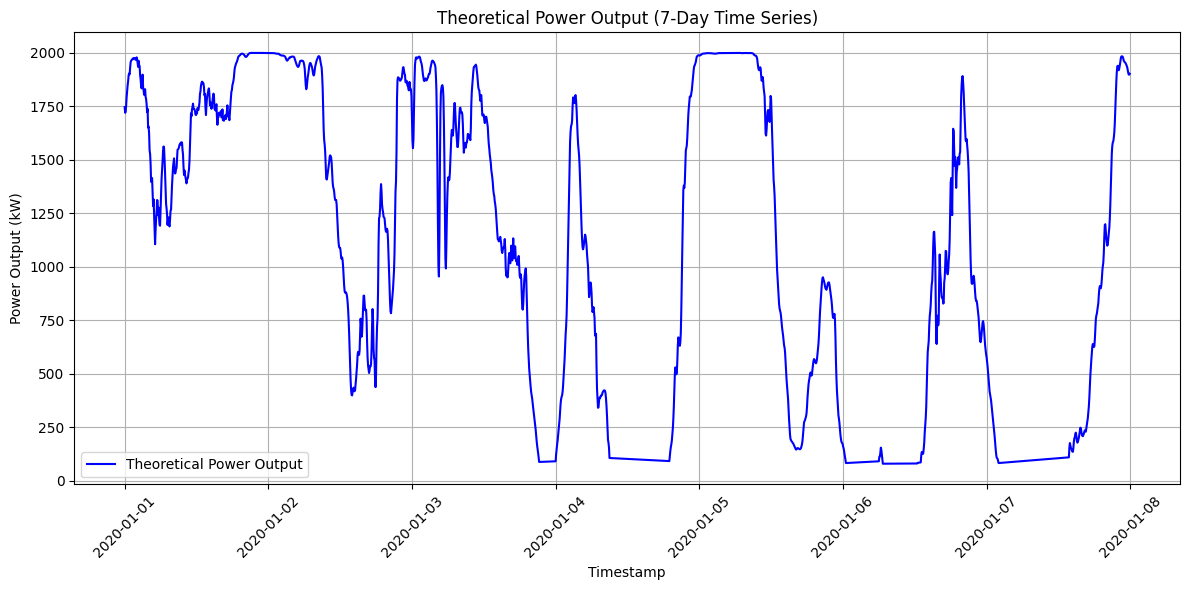

In [ ]:
# Filter the data for the first 7 days
start_date = df_cleaned['Timestamp'].min()
end_date = start_date + pd.Timedelta(days=7)
df_7_days = df_cleaned[(df_cleaned['Timestamp'] >= start_date) & (df_cleaned['Timestamp'] < end_date)]

# Step 2: Plot the theoretical power output as a time series
plt.figure(figsize=(12, 6))
plt.plot(df_7_days['Timestamp'], df_7_days['theoretical_power_output (kW)'], label='Theoretical Power Output', color='blue')
plt.title('Theoretical Power Output (7-Day Time Series)')
plt.xlabel('Timestamp')
plt.ylabel('Power Output (kW)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Filtering the First 7 Days:

The same filtering logic is applied as in the earlier time series plot for theoretical power output.

Capacity Factor Calculation:

Capacity Factor (%) = Theoretical Power Output (kW)/ Rated Capacity (kW) × 100

This calculation is done for each timestamp in the 7-day range.

Plotting:

The capacity factor is plotted as a percentage on the y-axis over the 7-day period.

Average Capacity Factor:
The mean capacity factor over the 7 days is calculated below.

In [ ]:
# Theoretical power output and maximum possible output
rated_capacity = 2000  # Replace with the rated capacity of your turbine in kW
df_7_days['capacity_factor'] = df_7_days['theoretical_power_output (kW)'] / rated_capacity * 100


average_capacity_factor = df_7_days['capacity_factor'].mean()
print(f"Average Capacity Factor over 7 Days: {average_capacity_factor:.2f}%")

Average Capacity Factor over 7 Days: 64.95%


<ipython-input-21-e8c3805a67d6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7_days['capacity_factor'] = df_7_days['theoretical_power_output (kW)'] / rated_capacity * 100


**Air Density**:
   Air density was calculated using the formula:
 $$ \rho = \frac{P}{R \cdot T} $$
   where:
   - \(P\): Air pressure in Pa
   - \(R = 287.0\): Specific gas constant for air
   - \(T\): Air temperature in Kelvin




---


   **Power Adjustment**:
   Adjusted power output was derived using:
$$ P_{\text{adjusted}} = P_{\text{original}} \cdot \frac{\rho_{\text{local}}}{\rho_{\text{reference}}} $$

<ipython-input-31-7ad20062cf6f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['air_temperature_kelvin'] = df_cleaned['air temperature at 100m (C)'] + 273.15
<ipython-input-31-7ad20062cf6f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['air_density (kg/m^3)'] = df_cleaned['air pressure at 100m (Pa)'] / (R * df_cleaned['air_temperature_kelvin'])
<ipython-input-31-7ad20062cf6f>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

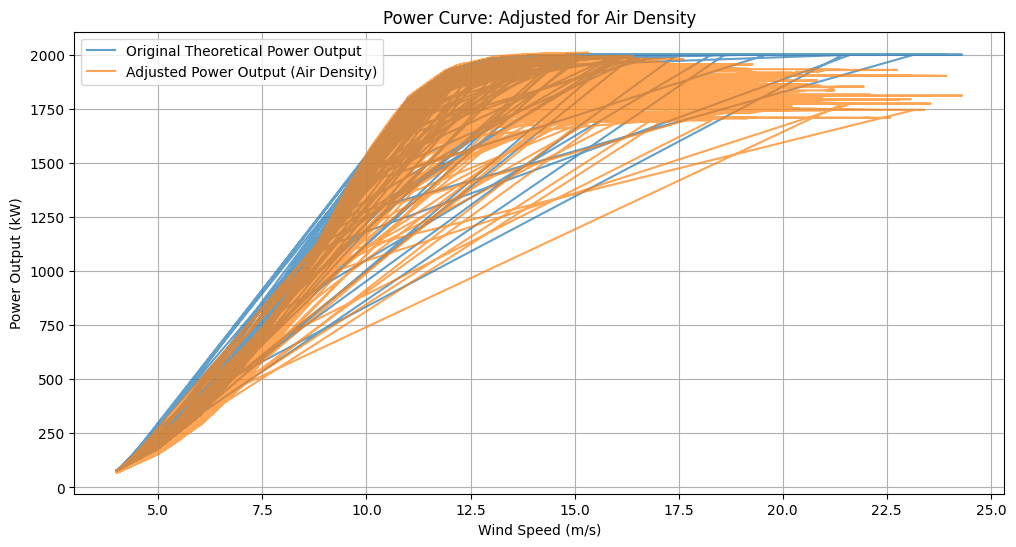

Summary of Air Density Adjustments:
    wind speed at 100m (m/s)  air_density (kg/m^3)  \
0                      10.82              1.170619   
1                      10.72              1.170619   
2                      10.74              1.170619   
3                      10.85              1.170619   
4                      11.00              1.170619   
5                      11.21              1.170619   
6                      11.40              1.170619   
7                      11.54              1.170619   
8                      11.74              1.170619   
9                      11.80              1.170619   
10                     11.77              1.170619   
11                     12.02              1.170619   
12                     12.51              1.171498   
13                     12.64              1.171498   
14                     12.70              1.171498   
15                     12.77              1.171498   
16                     12.84              1.17

In [ ]:
# Step 1: Calculate air density
# Constants
R = 287.0  # Specific gas constant for air in J/(kg·K)

# Convert air temperature to Kelvin
df_cleaned['air_temperature_kelvin'] = df_cleaned['air temperature at 100m (C)'] + 273.15

# Calculate air density using the formula: ρ = P / (R * T)
df_cleaned['air_density (kg/m^3)'] = df_cleaned['air pressure at 100m (Pa)'] / (R * df_cleaned['air_temperature_kelvin'])

# Step 2: Adjust the power curve using air density
# Reference air density (standard conditions at sea level)
reference_air_density = 1.225  # kg/m^3

# Function to adjust power output based on air density
def adjust_power_output(power_output, air_density, reference_density=1.225):
    return power_output * (air_density / reference_density)

# Apply the adjustment to the theoretical power output
df_cleaned['adjusted_power_output (kW)'] = adjust_power_output(
    df_cleaned['theoretical_power_output (kW)'],
    df_cleaned['air_density (kg/m^3)']
)

# Step 3: Visualization of the Adjusted Power Curve
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['wind speed at 100m (m/s)'], df_cleaned['theoretical_power_output (kW)'], label='Original Theoretical Power Output', alpha=0.7)
plt.plot(df_cleaned['wind speed at 100m (m/s)'], df_cleaned['adjusted_power_output (kW)'], label='Adjusted Power Output (Air Density)', alpha=0.7)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('Power Curve: Adjusted for Air Density')
plt.legend()
plt.grid()
plt.show()

# Step 4: Summary Statistics
print("Summary of Air Density Adjustments:")
print(df_cleaned[['wind speed at 100m (m/s)', 'air_density (kg/m^3)', 'theoretical_power_output (kW)', 'adjusted_power_output (kW)']].head(43))

### **Visualization**
Above and below is a plot comparing the theoretical power output and the adjusted power output, highlighting the impact of air density variations:


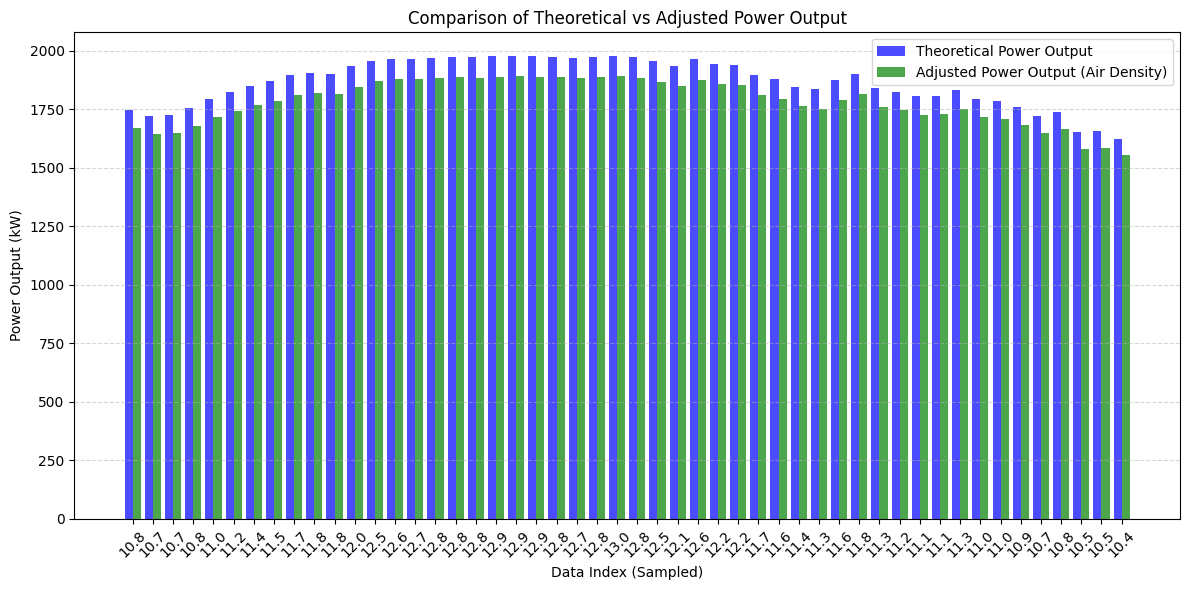

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Create a sample of the data for better visualization (if data is large)
df_sampled = df_cleaned.head(50)  # Use the first 50 rows or adjust as needed

# Step 2: Plot the bar chart
x = np.arange(len(df_sampled))  # Create indices for x-axis
width = 0.4  # Width of the bars

plt.figure(figsize=(12, 6))

# Bar for theoretical power output
plt.bar(x - width/2, df_sampled['theoretical_power_output (kW)'], width, label='Theoretical Power Output', color='blue', alpha=0.7)

# Bar for adjusted power output
plt.bar(x + width/2, df_sampled['adjusted_power_output (kW)'], width, label='Adjusted Power Output (Air Density)', color='green', alpha=0.7)

# Add labels and title
plt.xlabel('Data Index (Sampled)')
plt.ylabel('Power Output (kW)')
plt.title('Comparison of Theoretical vs Adjusted Power Output')
plt.xticks(x, df_sampled['wind speed at 100m (m/s)'].round(1), rotation=45)  # Use wind speed as x-axis labels
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


## **Energy Production and Capacity Factor**
Using the adjusted power curve and the time series data, the theoretical energy production was estimated for each 5-minute interval. The total energy production was scaled to annual values to calculate the **capacity factor**.

### **Key Metrics**
- **Total Energy Production(Dataset)**: 8353.74 MWh
- **Annual Energy Production (Estimated)**: 8330.99 MWh
- **Capacity Factor (7 day AVG)**: 64.95%

### **Code Implementation**


<ipython-input-30-cf19f0ba4ee6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['energy_generated_kWh'] = df_cleaned['adjusted_power_output (kW)'] * time_interval_hours
<ipython-input-30-cf19f0ba4ee6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cumulative_energy_MWh'] = df_cleaned['energy_generated_kWh'].cumsum() / 1000


Total Energy Production for the Dataset Period: 8353.74 MWh
Estimated Annual Energy Production: 8330.99 MWh


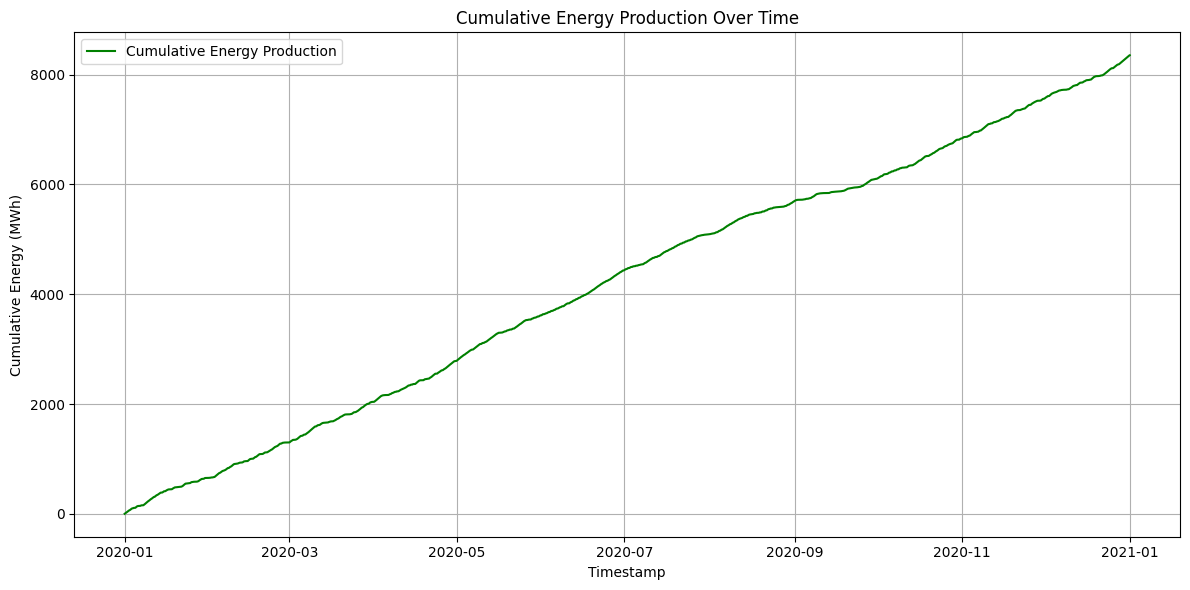

In [ ]:
# Step 1: Calculate energy generated at each timestamp
# Assuming the time interval in the dataset is uniform and in minutes
time_interval_minutes = 5  # Time interval in minutes
time_interval_hours = time_interval_minutes / 60  # Convert to hours

# Calculate energy for each timestamp in kWh (Power Output * Time)
df_cleaned['energy_generated_kWh'] = df_cleaned['adjusted_power_output (kW)'] * time_interval_hours

# Step 2: Calculate total energy production for the dataset period
total_energy_production_kWh = df_cleaned['energy_generated_kWh'].sum()
total_energy_production_MWh = total_energy_production_kWh / 1000  # Convert to MWh
print(f"Total Energy Production for the Dataset Period: {total_energy_production_MWh:.2f} MWh")

# Step 3: Annualize the energy production (if the dataset covers less than a year)
# Find the time span of the dataset in hours
time_span_hours = (df_cleaned['Timestamp'].max() - df_cleaned['Timestamp'].min()).total_seconds() / 3600
annual_energy_production_MWh = (total_energy_production_kWh / time_span_hours) * (24 * 365) / 1000  # Scale to 1 year

print(f"Estimated Annual Energy Production: {annual_energy_production_MWh:.2f} MWh")

# Step 4: Visualization of Energy Yield Over Time
import matplotlib.pyplot as plt

# Cumulative Energy Production Over Time
df_cleaned['cumulative_energy_MWh'] = df_cleaned['energy_generated_kWh'].cumsum() / 1000

plt.figure(figsize=(12, 6))
plt.plot(df_cleaned['Timestamp'], df_cleaned['cumulative_energy_MWh'], label='Cumulative Energy Production', color='green')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Energy (MWh)')
plt.title('Cumulative Energy Production Over Time')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


### **Conclusion**
This project successfully analyzed the wind resource potential for the Lone Star Wind Farm using open-source data from NREL. Key findings include:
- A reliable wind resource with a Weibull shape parameter (k) of 2.92.
- Adjusted power output improved energy yield accuracy by accounting for air density.
- Seasonal and hourly trends provided insights for optimizing turbine performance.

Future work can include:
1. Incorporating SCADA data for operational validation.
2. Analyzing downtime and wake losses for comprehensive loss evaluation.
3. Expanding the analysis to multiple turbines and larger datasets.

Thank you for reviewing this project!
